# Fine-Tuning переднавченої моделі

## Передобробка даних

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import zipfile
from pathlib import Path

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

## Завантаження датасету

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Files/TT-3_project-20240718T093326Z-001.zip'
temp_path = '/content/temp/'
data_path = '/content/data/'
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall(temp_path)

path = Path(temp_path+"/TT-3_project/")
for file in path.iterdir():
  with zipfile.ZipFile(file, 'r') as zip_file:
    zip_file.extractall(data_path)

In [ ]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
test_labels = pd.read_csv("data/test_labels.csv")

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
# !nvidia-smi

In [ ]:
# Перевірка доступності GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


### Data Visualization to Understand Class Distribution

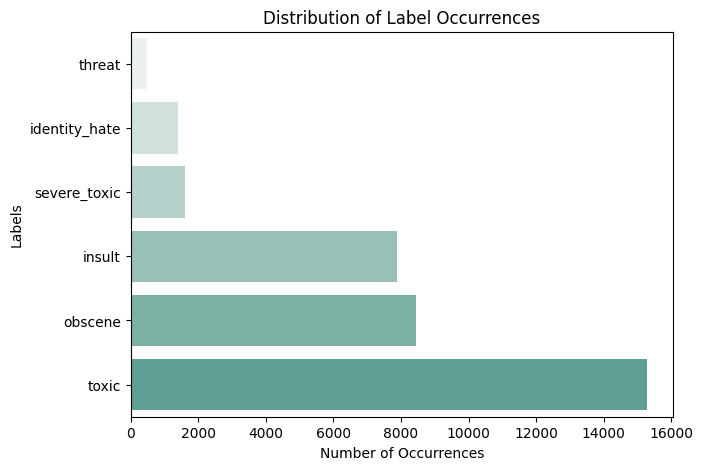

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the class distribution of the 'label' column
column_labels = train.columns.tolist()[2:]
label_counts = train[column_labels].sum().sort_values()

plt.figure(figsize=(7, 5))
ax = sns.barplot(x=label_counts.values, y=label_counts.index, hue=label_counts.index, palette="light:#5A9")


plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

plt.show()

In [ ]:
train[column_labels].sum().sort_values()

,0
threat,478
identity_hate,1405
severe_toxic,1595
insult,7877
obscene,8449
toxic,15294


## Токсичні і нетоксичні дані

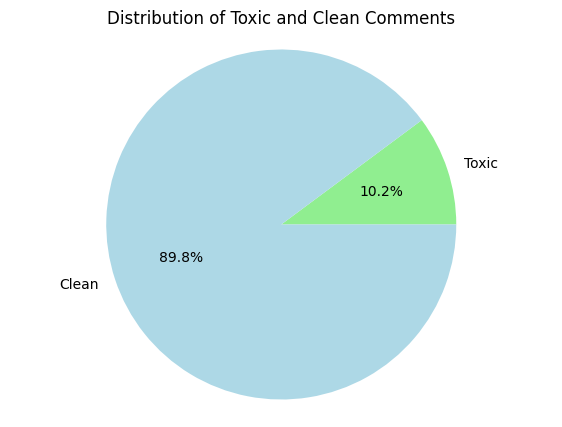

In [ ]:
# Створення підмножин на основі токсичних та чистих коментарів
train_toxic = train[train[column_labels].sum(axis=1) > 0]
train_clean = train[train[column_labels].sum(axis=1) == 0]

# Кількість токсичних та чистих коментарів
num_toxic = len(train_toxic)
num_clean = len(train_clean)

plot_data = pd.DataFrame({'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})
colors=['lightgreen', 'lightblue']
plt.figure(figsize=(7, 5))
plt.pie(plot_data['Count'], labels=plot_data['Category'], colors = colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Toxic and Clean Comments')
plt.show()

In [ ]:
print(train_toxic.shape)
print(train_clean.shape)

(16225, 8)
(143346, 8)


## Вирівнювання дисбалансу

In [ ]:
# Randomly sample 16,225 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
df = dataframe.sample(frac=0.1, random_state=42)

In [ ]:
column_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
train.shape

(159571, 8)

In [ ]:
train_df = train[train.toxic != -1] # нема сенсу, таких тут нема
train_df = df
print(train_df.shape)
train_df.head()

(3245, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
57737,9a8103881a1d8372,You are an old cougar! You are an old cougar!,1,0,0,0,1,0
46617,7c9a37dc040d6ef4,I'm scared\nbrrrr.... i'm gonna die now,0,0,0,0,0,0
83356,df07677ce31a782d,"Okay, so anal sex is as widely unaccepted and ...",1,0,0,0,0,0
34637,5c854590da41ac65,shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...,1,0,1,0,1,0
27887,49cfe7691eb59201,You arrogant administrator homosexual bastards...,1,1,1,0,1,1


In [ ]:
train_df.shape

(3245, 8)

In [ ]:
# df = df[df.toxic != -1]

In [ ]:
# df.columns

## Очищення даних

In [ ]:
!pip install bs4

In [ ]:
# # Пуктуацію треба залишити!

# from bs4 import BeautifulSoup
# import re

# # Приклад preprocess_text функції, яка видаляє HTML-теги, лінки та зайві символи
# def preprocess_text(text):
#     # Видалення HTML-тегів
#     text = BeautifulSoup(text, 'html.parser').get_text()
#     # Видалення лінків
#     text = re.sub(r'http\S+', '', text)
#     # Видалення зайвих символів
#     text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
#     return text

# # Використання функції apply для застосування preprocess_text до кожного елемента стовпця comment_text
# df['comment_text'] = df['comment_text'].apply(preprocess_text)

# print(df)

                     id                                       comment_text  \
57737  9a8103881a1d8372        You are an old cougar You are an old cougar   
46617  7c9a37dc040d6ef4                  Im scared\nbrrrr im gonna die now   
83356  df07677ce31a782d  Okay so anal sex is as widely unaccepted and d...   
34637  5c854590da41ac65  shut up you cunt\nWWWWWWWWWWWWWWWWWWWWWWWWWWWW...   
27887  49cfe7691eb59201  You arrogant administrator homosexual bastards...   
...                 ...                                                ...   
25369  432a61e65a47309f  \n\n RE Life on Mars refs \n\nThanks nice of y...   
9958   1a5c51eba4acd8d4                             hi mat damen MAT DAMON   
64605  acec60348ea3ef1c  \nRight indeed Theres probably a way to do act...   
61814  a567718d0446ef51                       Youre a little control freak   
79863  d5b0f0747f0c1742  \nId assumed that youd simply have to remove t...   

       toxic  severe_toxic  obscene  threat  insult  identity_h

In [ ]:
# Новий варіант
import re
import string

def clean_text(text):

    #pattern = [zero or more character]
    text = re.sub('\[.*?\]', '', text)

    #pattern = removes (http),://, 'and' www.
    text = re.sub('https?://\S+|www\.\S+', '', text)

    #pattern = any punctionation
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    #pattern = any new line
    text = re.sub('\n', '', text)

    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]
    text = re.sub('\w*\d\w*', '', text)

    return text


df['comment_text'] = df['comment_text'].apply(clean_text)

print(df)

                     id                                       comment_text  \
57737  9a8103881a1d8372        You are an old cougar You are an old cougar   
46617  7c9a37dc040d6ef4                    Im scaredbrrrr im gonna die now   
83356  df07677ce31a782d  Okay so anal sex is as widely unaccepted and d...   
34637  5c854590da41ac65  shut up you cuntWWWWWWWWWWWWWWWWWWWWWWWWWWWWWW...   
27887  49cfe7691eb59201  You arrogant administrator homosexual bastards...   
...                 ...                                                ...   
25369  432a61e65a47309f   RE Life on Mars refs Thanks nice of you to sa...   
9958   1a5c51eba4acd8d4                             hi mat damen MAT DAMON   
64605  acec60348ea3ef1c  Right indeed Theres probably a way to do actua...   
61814  a567718d0446ef51                       Youre a little control freak   
79863  d5b0f0747f0c1742  Id assumed that youd simply have to remove the...   

       toxic  severe_toxic  obscene  threat  insult  identity_h

In [ ]:
text = '''<p>Explanation Why the edits made under my username Hardcore Metallica Fan were reverted?</p> \n\n\nThey weren't vandalisms,  just closure on some GAs after I voted at New York Dolls FAC. www.amazon.com/ \nAnd please don't remove the template from the talk page since I'm retired now.89.205.38.27'''

In [ ]:
clean_text(text)

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms  just closure on some GAs after I voted at New York Dolls FAC  And please dont remove the template from the talk page since Im retired '

In [ ]:
print(train_toxic.shape)
print(train_clean_sampled.shape)
print(dataframe.shape)

(16225, 8)
(16225, 8)
(32450, 8)


In [ ]:
# Створення міток
labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
labels[10007]

array([1, 0, 1, 0, 1, 0])

## Розділення датасету на тренувальну, валідаційну та тестову вибірки

In [ ]:
# Розділення на тренувальний, валідаційний та тестовий набори
texts = df['comment_text']
labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [ ]:
# Токенізація текстів
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

In [ ]:
# Створення міток
train_labels = train_labels.values
val_labels = val_labels.values
test_labels = test_labels.values

In [ ]:
train_labels.shape, val_labels.shape, test_labels.shape

((2596, 6), (324, 6), (325, 6))

In [ ]:
# Створення Dataset класу
class ToxicCommentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [ ]:
train_dataset = ToxicCommentDataset(train_encodings, train_labels)
val_dataset = ToxicCommentDataset(val_encodings, val_labels)
test_dataset = ToxicCommentDataset(test_encodings, test_labels)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, WeightedRandomSampler
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

In [ ]:
# Обчислення ваг класів
label_counts = (train_labels != 0).sum(axis=0)
total_counts = len(train_labels)
class_weights = total_counts / (label_counts * len(label_counts))
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)  # Переносимо ваги на GPU, якщо доступно


In [ ]:
# Створення моделі
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
model.to(device)  # Переносимо модель на GPU, якщо доступно

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [ ]:
# Функція для обчислення метрик
def compute_metrics(p):
    preds = (p.predictions > 0.5).astype(int)
    labels = p.label_ids

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_fscore_support

# Налаштування функції втрат з вагами класів та оптимізатора
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").to(device)  # Переносимо мітки на GPU, якщо доступно
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss

    def create_optimizer_and_scheduler(self, num_training_steps: int):
        optimizer = AdamW(self.model.parameters(), lr=5e-5, weight_decay=0.01)
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=num_training_steps)

    def evaluate(self, eval_dataset=None, ignore_keys=None):
        # Оцінка моделі
        eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
        eval_dataloader = DataLoader(eval_dataset, batch_size=self.args.per_device_eval_batch_size)
        model.eval()
        all_labels = []
        all_preds = []
        eval_loss = 0
        for batch in eval_dataloader:
            with torch.no_grad():
                inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
                labels = batch["labels"].to(device)
                outputs = model(**inputs)
                logits = outputs.logits
                loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)
                loss = loss_fct(logits, labels.float())
                eval_loss += loss.item()
                preds = torch.sigmoid(logits).cpu().numpy()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds)

        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds) > 0.5  # Перетворення прогнозів у бінарні значення

        eval_loss = eval_loss / len(eval_dataloader)
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
        report = classification_report(all_labels, all_preds, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("Classification Report:\n", report)

        return {'eval_loss': eval_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'classification_report': report}

In [ ]:
# Налаштування тренера
training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    evaluation_strategy="epoch",     # Evaluate every epoch
    save_strategy="epoch",           # Save checkpoints every epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    save_total_limit=1,              # Limit the total amount of checkpoints.
    load_best_model_at_end=True,     # Load the best model at the end of training.
    metric_for_best_model="eval_loss",
    greater_is_better=False
)


NameError: name 'TrainingArguments' is not defined

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # використання валідаційного датасету
    compute_metrics=compute_metrics  # Додавання функції метрик
)


In [ ]:
# Запуск навчання
train_result = trainer.train()

Step,Training Loss,Validation Loss


Accuracy: 0.4352
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Classification Report:
                precision    recall  f1-score   support

        toxic       0.00      0.00      0.00       170
 severe_toxic       0.00      0.00      0.00        17
      obscene       0.00      0.00      0.00       100
       threat       0.00      0.00      0.00         6
       insult       0.00      0.00      0.00        89
identity_hate       0.00      0.00      0.00        14

    micro avg       0.00      0.00      0.00       396
    macro avg       0.00      0.00      0.00       396
 weighted avg       0.00      0.00      0.00       396
  samples avg       0.00      0.00      0.00       396

Accuracy: 0.4352
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Classification Report:
                precision    recall  f1-score   support

        toxic       0.00      0.00      0.00       170
 severe_toxic       0.00      0.00      0.00        17
      obscene       0.00      0.00      0.00

In [ ]:
# Toxic Comment Classification using BERT v0.2.ipynb
# print(f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}')

In [ ]:
# Збереження історії тренування в змінну
training_history = train_result.metrics

# Збереження історії тренування в змінну
training_history = trainer.state.log_history

# Перетворення історії в DataFrame для зручності
history_df = pd.DataFrame(training_history)
history_df.columns

Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'train_runtime',
       'train_samples_per_second', 'train_steps_per_second', 'total_flos',
       'train_loss'],
      dtype='object')

In [ ]:
history_df

,loss,grad_norm,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.5864,2.043148,4.897751e-05,0.061350,10,NaN,NaN,NaN,NaN,NaN
1,0.4661,1.351155,4.795501e-05,0.122699,20,NaN,NaN,NaN,NaN,NaN
2,0.5317,2.103386,4.693252e-05,0.184049,30,NaN,NaN,NaN,NaN,NaN
3,0.4118,1.041905,4.591002e-05,0.245399,40,NaN,NaN,NaN,NaN,NaN
4,0.3735,2.583123,4.488753e-05,0.306748,50,NaN,NaN,NaN,NaN,NaN
5,0.3412,1.259710,4.386503e-05,0.368098,60,NaN,NaN,NaN,NaN,NaN
6,0.2875,1.174087,4.284254e-05,0.429448,70,NaN,NaN,NaN,NaN,NaN
7,0.3148,3.228045,4.182004e-05,0.490798,80,NaN,NaN,NaN,NaN,NaN
8,0.3499,1.157501,4.079755e-05,0.552147,90,NaN,NaN,NaN,NaN,NaN
9,0.3547,8.581136,3.977505e-05,0.613497,100,NaN,NaN,NaN,NaN,NaN


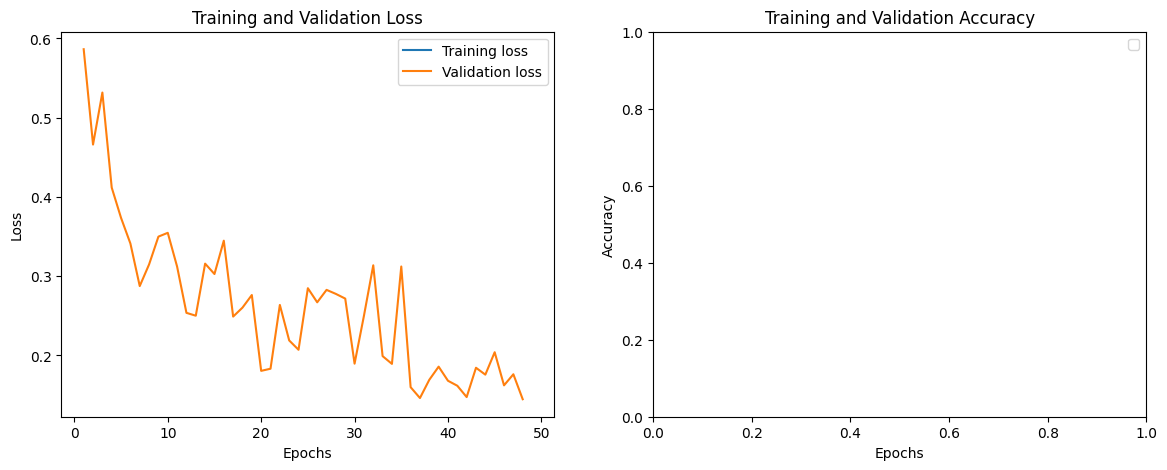

In [ ]:
import matplotlib.pyplot as plt

# Побудова графіків втрат і точності
def plot_training_history(history):
    epochs = range(1, len(history['epoch']) + 1)

    # Графік втрат
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_df['train_loss'], label='Training loss')
    plt.plot(epochs, history_df['loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Графік точності
    plt.subplot(1, 2, 2)
    # plt.plot(epochs, history_df['train_accuracy'], label='Training Accuracy')
    # plt.plot(epochs, history_df['accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.show()

# Виклик функції для побудови графіків
plot_training_history(history_df)

In [ ]:
# Оцінка моделі
trainer.evaluate(eval_dataset=test_dataset)

Accuracy: 0.7045
Precision: 0.8350
Recall: 0.8318
F1-Score: 0.8314


{'accuracy': 0.7044684129429892,
 'precision': 0.8350116977447594,
 'recall': 0.8317515099223468,
 'f1': 0.8314251373306518}

In [ ]:
# Збереження натренованої моделі
model.save_pretrained('./final_model')
tokenizer.save_pretrained('./final_model')

('./final_model/tokenizer_config.json',
 './final_model/special_tokens_map.json',
 './final_model/vocab.txt',
 './final_model/added_tokens.json')

In [ ]:
model.save_pretrained('/content/drive/MyDrive/final_model')
tokenizer.save_pretrained('/content/drive/MyDrive/final_model')

In [ ]:
# Функція для передбачення
def predict(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.sigmoid(logits).cpu().numpy()
    return probs


In [ ]:
# Приклад використання функції передбачення
sample_text = "This is an example comment."
predictions = predict(sample_text, model, tokenizer)
print(f"Predictions for '{sample_text}': {predictions}")

Predictions for 'This is an example comment.': [[0.00464556 0.00090045 0.00171404 0.00155481 0.00125459 0.00114692]]


In [ ]:
# Преобразование результатов в бинарные метки
binary_predictions = (predictions > 0.5).astype(int)
print(f"Binary Predictions for '{sample_text}': {binary_predictions}")

Binary Predictions for 'This is an example comment.': [[0 0 0 0 0 0]]


In [ ]:
#ось досюдова виконати

## Split Data into Training, Validation, and Testing Sets

In [ ]:
# Розділення на тексти та мітки
texts = df['comment_text']
labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Розділення на тренувальний, валідаційний та тестовий набори
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

# Ініціалізація BERT токенайзера
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Функція для токенізації та кодування тексту
def tokenize_and_encode(tokenizer, texts, labels, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,                      # Текст для токенізації
            add_special_tokens=True,   # Додавання спеціальних токенів ([CLS] і [SEP])
            max_length=max_length,     # Максимальна довжина тексту
            truncation=True,           # Увімкнення усічення
            padding='max_length',      # Додавання відступів до max_length
            return_attention_mask=True,# Повернення маски уваги
            return_tensors='pt'        # Повернення тензорів PyTorch
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values) if isinstance(labels, pd.DataFrame) else torch.tensor(labels)

    return input_ids, attention_masks, labels

# Токенізація та кодування коментарів для тренувального набору
train_input_ids, train_attention_masks, train_labels = tokenize_and_encode(
    tokenizer,
    train_texts,
    train_labels
)

# Токенізація та кодування коментарів для валідаційного набору
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_texts,
    val_labels
)

# Токенізація та кодування коментарів для тестового набору
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_texts,
    test_labels
)

print('Training Comments :', train_texts.shape)
print('Input Ids        :', train_input_ids.shape)
print('Attention Mask   :', train_attention_masks.shape)
print('Labels           :', train_labels.shape)

print('Validation Comments :', val_texts.shape)
print('Input Ids          :', val_input_ids.shape)
print('Attention Mask     :', val_attention_masks.shape)
print('Labels             :', val_labels.shape)

print('Test Comments :', test_texts.shape)
print('Input Ids     :', test_input_ids.shape)
print('Attention Mask:', test_attention_masks.shape)
print('Labels        :', test_labels.shape)


In [ ]:
print(type(train_texts))
print(type(val_texts))
print(type(test_texts))
print(type(train_labels))
print(type(val_labels))
print(type(test_labels))

In [ ]:
# Складний варіант з новим класом
from torch.utils.data import Dataset, DataLoader

class ToxicCommentsDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Створення датасетів
train_dataset = ToxicCommentsDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = ToxicCommentsDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = ToxicCommentsDataset(test_input_ids, test_attention_masks, test_labels)

# Створення DataLoader для кожного набору
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Перевірка першого батчу з тренувального DataLoader
for batch in train_loader:
    print(batch)
    break


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Створення TensorDataset для тренувального, валідаційного та тестового наборів
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Створення DataLoader для кожного набору
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Перевірка першого батчу з тренувального DataLoader
for batch in train_loader:
    input_ids, attention_mask, labels = batch
    print(f'Input IDs: {input_ids.shape}')
    print(f'Attention Mask: {attention_mask.shape}')
    print(f'Labels: {labels.shape}')
    break

### Обучение

In [ ]:
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import torch
from sklearn.metrics import accuracy_score

# Ініціалізація моделі BERT для класифікації
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)  # Вказати кількість класів

# Визначення функції втрат та оптимізатора
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_loader) * 4  # Кількість етапів навчання (наприклад, 4 епохи)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import numpy as np

def train_model(model, train_loader, val_loader, optimizer, scheduler, device):
    model.to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss()  # Використовуємо BCEWithLogitsLoss для багатокласової класифікації
    for epoch in range(4):  # Кількість епох
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            # Перетворення міток у Float
            labels = labels.float()

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)  # Використання BCEWithLogitsLoss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}")

        # Оцінка на валідаційному наборі
        model.eval()
        val_predictions, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [x.to(device) for x in batch]

                # Перетворення міток у Float
                labels = labels.float()

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                predictions = torch.sigmoid(logits).cpu().numpy() > 0.5  # Прогнозування міток
                val_predictions.extend(predictions)
                val_labels.extend(labels.cpu().numpy())

        val_predictions = np.array(val_predictions)
        val_labels = np.array(val_labels)
        accuracy = accuracy_score(val_labels, val_predictions)
        print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy}")

# Налаштування пристрою
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Тренування моделі
train_model(model, train_loader, val_loader, optimizer, scheduler, device)

# Оцінка моделі на тестовому наборі
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        # Перетворення міток у Float
        labels = labels.float()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.sigmoid(logits).cpu().numpy() > 0.5  # Прогнозування міток
        test_predictions.extend(predictions)
        test_labels.extend(labels.cpu().numpy())

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# # Перевірка розмірів тензорів
# print(f'Train input IDs shape: {train_input_ids.shape}')
# print(f'Train attention masks shape: {train_attention_masks.shape}')
# print(f'Train labels shape: {train_labels.shape}')
# print(f'Validation input IDs shape: {val_input_ids.shape}')
# print(f'Validation attention masks shape: {val_attention_masks.shape}')
# print(f'Validation labels shape: {val_labels.shape}')
# print(f'Test input IDs shape: {test_input_ids.shape}')
# print(f'Test attention masks shape: {test_attention_masks.shape}')
# print(f'Test labels shape: {test_labels.shape}')

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(model, test_loader, device):
    model.eval()
    test_predictions, test_labels = [], []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            labels = labels.float()  # Перетворення міток у Float

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.sigmoid(logits).cpu().numpy() > 0.5  # Прогнозування міток

            test_predictions.extend(predictions)
            test_labels.extend(labels.cpu().numpy())

    test_predictions = np.array(test_predictions)
    test_labels = np.array(test_labels)

    accuracy = accuracy_score(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions, average='weighted')
    recall = recall_score(test_labels, test_predictions, average='weighted')
    f1 = f1_score(test_labels, test_predictions, average='weighted')
    report = classification_report(test_labels, test_predictions, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test F1 Score: {f1}")
    print("\nClassification Report:\n", report)

# Виклик функції оцінки моделі
evaluate_model(model, test_loader, device)

In [ ]:
def preprocess_comment(tokenizer, comment, max_length=128):
    encoding = tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding['input_ids'], encoding['attention_mask']

def predict_toxicity(model, tokenizer, comment, device):
    model.eval()

    input_ids, attention_mask = preprocess_comment(tokenizer, comment)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.sigmoid(logits).cpu().numpy() > 0.5  # Прогнозування міток

    return predictions[0]

# Приклад використання функції прогнозування
comment = "This is an example comment."
predicted_labels = predict_toxicity(model, tokenizer, comment, device)

# Відображення результатів
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
result = {label: bool(pred) for label, pred in zip(toxic_labels, predicted_labels)}

print("Comment:", comment)
print("Predicted Toxicity Labels:", result)

In [ ]:
import torch

# Функція для збереження моделі та токенайзера
def save_model_and_tokenizer(model, tokenizer, model_path, tokenizer_path):
    # Збереження моделі
    torch.save(model.state_dict(), model_path)

    # Збереження токенайзера
    tokenizer.save_pretrained(tokenizer_path)

# Шляхи для збереження моделі та токенайзера
model_path = 'bert_toxic_comment_model.pth'
tokenizer_path = 'bert_toxic_comment_tokenizer'

# Виклик функції для збереження
save_model_and_tokenizer(model, tokenizer, model_path, tokenizer_path)


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Функція для завантаження моделі та токенайзера
def load_model_and_tokenizer(model_path, tokenizer_path, num_labels):
    # Завантаження токенайзера
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

    # Завантаження моделі
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    )
    model.load_state_dict(torch.load(model_path))

    return model, tokenizer

# Шляхи для завантаження моделі та токенайзера
model_path = 'bert_toxic_comment_model.pth'
tokenizer_path = 'bert_toxic_comment_tokenizer'
num_labels = 6

# Виклик функції для завантаження
model, tokenizer = load_model_and_tokenizer(model_path, tokenizer_path, num_labels)

# Переклад моделі на потрібний пристрій (CPU або GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Налаштування гіперпараметрів
learning_rate = 2e-5
batch_size = 16
epochs = 3

# Оптимізатор і розкладка навчальної швидкості
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)

# Функція тренування з налаштуванням гіперпараметрів
def train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=3):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss}")

        # Оцінка на валідаційному наборі
        evaluate_model(model, val_loader, device)

# Тренування моделі
train_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=epochs)

# Оцінка на тестовому наборі
evaluate_model(model, test_loader, device)
